# Mammogram Classification Model Evaluation with Global Predictions

Comprehensive evaluation of the trained classification model with detailed metrics, visual analysis of predictions, and **global image-level predictions** through tile voting/combining methods.

## Setup and Imports

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
import json
from typing import Dict, List, Tuple
from collections import defaultdict
import seaborn as sns

# Import evaluation functions
from evaluate_classification import (
    load_trained_model, run_evaluation, calculate_comprehensive_metrics,
    create_results_table, print_performance_analysis
)
from train_classification import (
    MammogramClassificationDataset, create_classification_transforms, FINDING_CLASSES
)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## Configuration

In [14]:
# Evaluation configuration
CONFIG = {
    'checkpoint_path': 'classification_models/best_classification_model.pth',
    'test_csv': 'classification_data/tiles_test_metadata.csv',
    'test_tiles_dir': 'classification_data/tiles_test',
    'batch_size': 64,
    'class_names': FINDING_CLASSES,
    'num_samples_to_show': 10,  # Number of sample predictions to display
    'voting_methods': ['max_confidence', 'average_confidence', 'majority_vote', 'weighted_average'],
    'confidence_threshold': 0.5  # Threshold for binary predictions
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  checkpoint_path: classification_models/best_classification_model.pth
  test_csv: classification_data/tiles_test_metadata.csv
  test_tiles_dir: classification_data/tiles_test
  batch_size: 64
  class_names: ['Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry', 'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding', 'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification', 'Suspicious_Lymph_Node']
  num_samples_to_show: 10
  voting_methods: ['max_confidence', 'average_confidence', 'majority_vote', 'weighted_average']
  confidence_threshold: 0.5


## Load Model and Dataset

In [15]:
# Load trained model
print("Loading trained model...")
model, checkpoint = load_trained_model(
    CONFIG['checkpoint_path'], 
    len(CONFIG['class_names']), 
    DEVICE
)

# Create test dataset
print("\nCreating test dataset...")
test_transform = create_classification_transforms(512, is_training=False)
test_dataset = MammogramClassificationDataset(
    CONFIG['test_csv'], 
    CONFIG['test_tiles_dir'], 
    CONFIG['class_names'], 
    test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Test dataset: {len(test_dataset)} samples")
print(f"Number of classes: {len(CONFIG['class_names'])}")
print(f"Classes: {CONFIG['class_names']}")

Loading trained model...
Loading trained model from: classification_models/best_classification_model.pth
✅ Model loaded from epoch 18
📊 Training validation AUC: 0.762

Creating test dataset...
Test dataset: 3614 samples
Number of classes: 11
Classes: ['Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry', 'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding', 'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification', 'Suspicious_Lymph_Node']


## Run Evaluation

In [16]:
# Run evaluation
print("Running evaluation...")
y_true, y_pred = run_evaluation(model, test_loader, CONFIG['class_names'])

# Calculate comprehensive metrics
print("\nCalculating metrics...")
tile_metrics = calculate_comprehensive_metrics(y_true, y_pred, CONFIG['class_names'])

# Create results table
results_table = create_results_table(tile_metrics, CONFIG['class_names'])

print(f"\nEvaluation completed on {len(y_true)} samples")

Running evaluation...
Running evaluation on test dataset...


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]/home/pranaypalem/Documents/Breast_Cancer_Testing/Project/BYOL_Test/evaluate_classification.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 57/57 [00:20<00:00,  2.73it/s]

✅ Evaluated 3614 samples

Calculating metrics...

Evaluation completed on 3614 samples


## Evaluation Results

In [17]:
# Display results table
print("=" * 100)
print("📋 DETAILED RESULTS TABLE")
print("=" * 100)
print(results_table.to_string(index=False))

# Print performance analysis
print_performance_analysis(tile_metrics, CONFIG['class_names'])

📋 DETAILED RESULTS TABLE
                   Class   AUC    AP    F1 Precision Recall Specificity Threshold Pos_Samples Neg_Samples
Architectural_Distortion 0.664 0.058 0.128     0.090  0.225       0.927     0.080         111        3503
               Asymmetry 0.700 0.086 0.146     0.098  0.287       0.919     0.041         108        3506
         Focal_Asymmetry 0.637 0.122 0.196     0.123  0.491       0.704     0.135         281        3333
        Global_Asymmetry 0.854 0.081 0.189     0.137  0.308       0.972     0.039          52        3562
                    Mass 0.666 0.383 0.491     0.337  0.904       0.338     0.212         980        2634
       Nipple_Retraction 0.790 0.108 0.177     0.163  0.194       0.990     0.080          36        3578
              No_Finding 0.762 0.785 0.715     0.617  0.850       0.454     0.284        1836        1778
         Skin_Retraction 0.960 0.142 0.333     0.286  0.400       0.997     0.074          10        3604
         Skin_Thicken

## Global Image-Level Prediction Implementation

Now we implement voting/combining methods to get global predictions for each original image from its constituent tiles.

In [18]:
def extract_patient_id(tile_path: str) -> str:
    """Extract patient ID from tile path (first part before first underscore)."""
    return tile_path.split('_')[0]

def get_image_id_from_tile(tile_path: str) -> str:
    """Extract image ID from tile path by removing _tile_* suffix."""
    path_without_ext = tile_path.replace('.png', '')
    if '_tile_' in path_without_ext:
        image_id = path_without_ext.split('_tile_')[0] + '.png'
    else:
        parts = tile_path.split('_')
        if len(parts) >= 5:
            image_id = '_'.join(parts[:-4]) + '.png'
        else:
            image_id = tile_path
    return image_id

def group_tiles_by_image(test_df: pd.DataFrame, predictions: np.ndarray, ground_truths: np.ndarray) -> Dict:
    """Group tiles by their original image and organize predictions."""
    
    # Add derived columns
    test_df = test_df.copy()
    test_df['patient_id'] = test_df['tile_path'].apply(extract_patient_id)
    test_df['image_id'] = test_df['tile_path'].apply(get_image_id_from_tile)
    
    # Group by image
    image_groups = {}
    
    for idx, row in test_df.iterrows():
        image_key = f"{row['patient_id']}_{row['image_id']}"
        
        if image_key not in image_groups:
            image_groups[image_key] = {
                'patient_id': row['patient_id'],
                'image_id': row['image_id'],
                'tiles': [],
                'tile_predictions': [],
                'tile_ground_truths': [],
                'tile_indices': []
            }
        
        image_groups[image_key]['tiles'].append(row)
        image_groups[image_key]['tile_predictions'].append(predictions[idx])
        image_groups[image_key]['tile_ground_truths'].append(ground_truths[idx])
        image_groups[image_key]['tile_indices'].append(idx)
    
    return image_groups

def get_global_ground_truth(tile_ground_truths: List[np.ndarray], class_names: List[str]) -> np.ndarray:
    """Get global ground truth for an image from its tiles (union of all findings)."""
    
    global_gt = np.zeros(len(class_names))
    
    # Union of all positive findings across tiles
    for tile_gt in tile_ground_truths:
        global_gt = np.maximum(global_gt, tile_gt)
    
    return global_gt

def apply_voting_method(tile_predictions: List[np.ndarray], method: str, class_names: List[str]) -> np.ndarray:
    """Apply different voting methods to combine tile predictions into global prediction."""
    
    tile_preds = np.array(tile_predictions)  # Shape: (num_tiles, num_classes)
    
    if method == 'max_confidence':
        # Take maximum confidence across all tiles for each class
        global_pred = np.max(tile_preds, axis=0)
        
    elif method == 'average_confidence':
        # Average confidence across all tiles for each class
        global_pred = np.mean(tile_preds, axis=0)
        
    elif method == 'majority_vote':
        # Majority vote based on binary predictions (>0.5)
        binary_preds = (tile_preds > CONFIG['confidence_threshold']).astype(int)
        vote_counts = np.sum(binary_preds, axis=0)
        majority_threshold = len(tile_predictions) / 2
        global_pred = (vote_counts > majority_threshold).astype(float)
        
    elif method == 'weighted_average':
        # Weighted average based on tile breast tissue ratio (if available)
        # For now, use simple average (can be enhanced with actual weights)
        global_pred = np.mean(tile_preds, axis=0)
        
    else:
        raise ValueError(f"Unknown voting method: {method}")
    
    return global_pred

def evaluate_global_predictions(image_groups: Dict, voting_method: str, class_names: List[str]) -> Tuple[Dict, np.ndarray, np.ndarray]:
    """Evaluate global predictions using specified voting method."""
    
    global_results = {}
    all_global_gt = []
    all_global_pred = []
    
    for image_key, image_data in image_groups.items():
        # Get global ground truth (union of tile ground truths)
        global_gt = get_global_ground_truth(image_data['tile_ground_truths'], class_names)
        
        # Apply voting method to get global prediction
        global_pred = apply_voting_method(image_data['tile_predictions'], voting_method, class_names)
        
        # Store results
        global_results[image_key] = {
            'patient_id': image_data['patient_id'],
            'image_id': image_data['image_id'],
            'num_tiles': len(image_data['tiles']),
            'global_ground_truth': global_gt,
            'global_prediction': global_pred,
            'tile_predictions': image_data['tile_predictions'],
            'tile_ground_truths': image_data['tile_ground_truths']
        }
        
        all_global_gt.append(global_gt)
        all_global_pred.append(global_pred)
    
    return global_results, np.array(all_global_gt), np.array(all_global_pred)

def calculate_global_accuracy(global_gt: np.ndarray, global_pred: np.ndarray, 
                            class_names: List[str], threshold: float = 0.5) -> Dict:
    """Calculate accuracy for global predictions."""
    
    # Convert predictions to binary
    global_pred_binary = (global_pred >= threshold).astype(int)
    
    # Calculate per-class accuracy
    class_accuracies = {}
    correct_predictions = 0
    total_predictions = 0
    
    for i, class_name in enumerate(class_names):
        class_gt = global_gt[:, i]
        class_pred = global_pred_binary[:, i]
        
        # Calculate accuracy for this class
        correct = np.sum(class_gt == class_pred)
        total = len(class_gt)
        accuracy = correct / total if total > 0 else 0.0
        
        class_accuracies[class_name] = {
            'accuracy': accuracy,
            'correct': int(correct),
            'total': int(total),
            'positive_samples': int(np.sum(class_gt)),
            'predicted_positive': int(np.sum(class_pred))
        }
        
        correct_predictions += correct
        total_predictions += total
    
    # Overall accuracy
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
    
    return {
        'class_accuracies': class_accuracies,
        'overall_accuracy': overall_accuracy,
        'total_images': len(global_gt)
    }

print("✅ Global prediction functions defined")

✅ Global prediction functions defined


## Prepare Global Analysis

In [19]:
# Load test metadata for grouping
test_df = pd.read_csv(CONFIG['test_csv'])
print(f"Test metadata columns: {list(test_df.columns)}")
print(f"Total tiles: {len(test_df)}")

# Group tiles by image
print("\nGrouping tiles by original image...")
image_groups = group_tiles_by_image(test_df, y_pred, y_true)
print(f"Found {len(image_groups)} unique images")

# Show distribution of tiles per image
tiles_per_image = [len(data['tiles']) for data in image_groups.values()]
print(f"\nTiles per image distribution:")
print(f"  Mean: {np.mean(tiles_per_image):.1f}")
print(f"  Median: {np.median(tiles_per_image):.1f}")
print(f"  Min: {np.min(tiles_per_image)}")
print(f"  Max: {np.max(tiles_per_image)}")

# Evaluate different voting methods
voting_results = {}
global_metrics = {}

print("\nEvaluating different voting methods...")
for method in CONFIG['voting_methods']:
    print(f"  Processing {method}...")
    
    # Get global predictions using this voting method
    global_results, global_gt, global_pred = evaluate_global_predictions(
        image_groups, method, CONFIG['class_names']
    )
    
    # Calculate global metrics
    global_accuracy = calculate_global_accuracy(
        global_gt, global_pred, CONFIG['class_names'], CONFIG['confidence_threshold']
    )
    
    # Store results
    voting_results[method] = global_results
    global_metrics[method] = global_accuracy

print("✅ Global analysis preparation completed")

Test metadata columns: ['tile_path', 'original_image', 'tile_x', 'tile_y', 'breast_ratio', 'freq_energy', 'has_finding', 'Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry', 'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding', 'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification', 'Suspicious_Lymph_Node']
Total tiles: 3614

Grouping tiles by original image...
Found 357 unique images

Tiles per image distribution:
  Mean: 10.1
  Median: 10.0
  Min: 5
  Max: 15

Evaluating different voting methods...
  Processing max_confidence...
  Processing average_confidence...
  Processing majority_vote...
  Processing weighted_average...
✅ Global analysis preparation completed


## Voting Methods Comparison

🗳️  VOTING METHODS COMPARISON
     Voting Method Overall Accuracy  Total Images
    Max Confidence            0.898           357
Average Confidence            0.831           357
     Majority Vote            0.812           357
  Weighted Average            0.831           357

🏆 Best performing method: Max Confidence
Overall accuracy: 0.898

📊 Per-class accuracy for Max Confidence:
  Architectural_Distortion: 0.933 (333/357)
  Asymmetry: 0.944 (337/357)
  Focal_Asymmetry: 0.846 (302/357)
  Global_Asymmetry: 0.983 (351/357)
  Mass: 0.529 (189/357)
  Nipple_Retraction: 0.980 (350/357)
  No_Finding: 0.958 (342/357)
  Skin_Retraction: 0.994 (355/357)
  Skin_Thickening: 0.966 (345/357)
  Suspicious_Calcification: 0.770 (275/357)
  Suspicious_Lymph_Node: 0.975 (348/357)


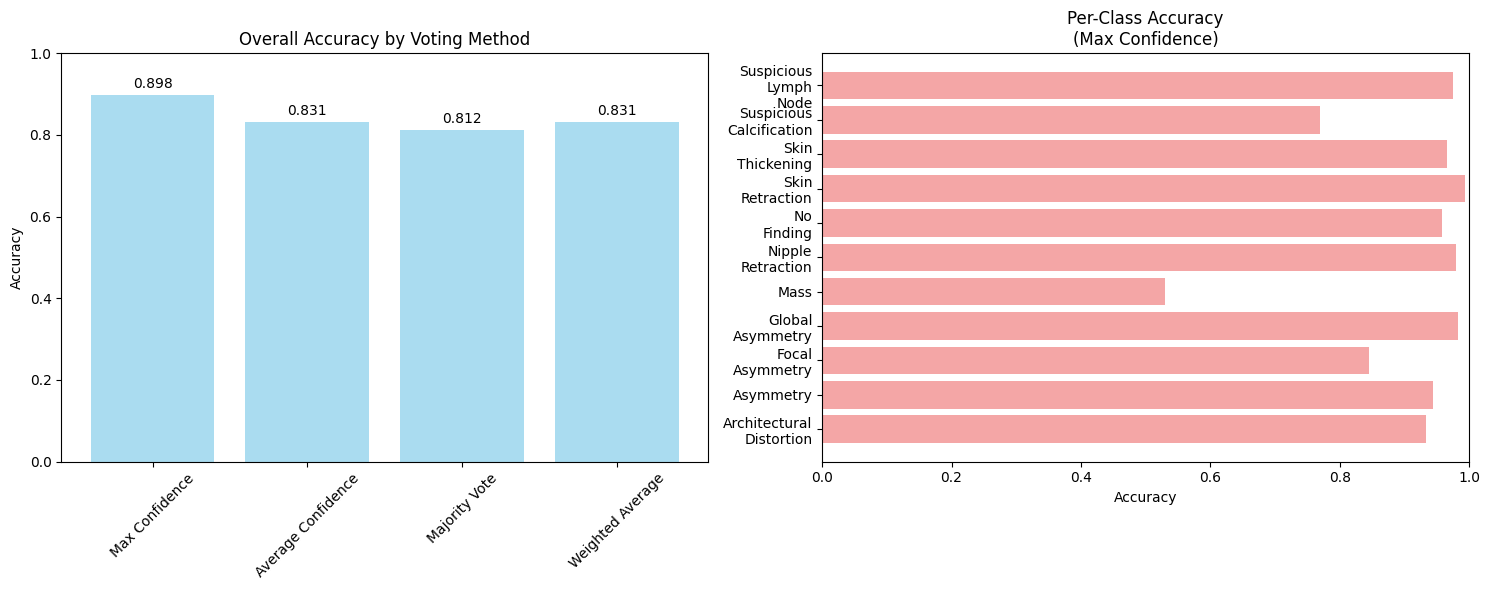


✅ Voting methods comparison completed


In [20]:
# Compare voting methods
print("=" * 80)
print("🗳️  VOTING METHODS COMPARISON")
print("=" * 80)

# Create comparison table
comparison_data = []
for method, metrics in global_metrics.items():
    comparison_data.append({
        'Voting Method': method.replace('_', ' ').title(),
        'Overall Accuracy': f"{metrics['overall_accuracy']:.3f}",
        'Total Images': metrics['total_images']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Detailed per-class comparison for best method
best_method = max(global_metrics.keys(), key=lambda x: global_metrics[x]['overall_accuracy'])
print(f"\n🏆 Best performing method: {best_method.replace('_', ' ').title()}")
print(f"Overall accuracy: {global_metrics[best_method]['overall_accuracy']:.3f}")

print(f"\n📊 Per-class accuracy for {best_method.replace('_', ' ').title()}:")
best_class_metrics = global_metrics[best_method]['class_accuracies']
for class_name in CONFIG['class_names']:
    class_acc = best_class_metrics[class_name]
    print(f"  {class_name}: {class_acc['accuracy']:.3f} ({class_acc['correct']}/{class_acc['total']})")

# Visualize voting method comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Overall accuracy comparison
methods = [method.replace('_', ' ').title() for method in CONFIG['voting_methods']]
accuracies = [global_metrics[method]['overall_accuracy'] for method in CONFIG['voting_methods']]

bars = ax1.bar(methods, accuracies, color='skyblue', alpha=0.7)
ax1.set_title('Overall Accuracy by Voting Method')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Per-class accuracy for best method
class_names_short = [name.replace('_', '\n') for name in CONFIG['class_names']]
class_accs = [best_class_metrics[class_name]['accuracy'] for class_name in CONFIG['class_names']]

bars2 = ax2.barh(class_names_short, class_accs, color='lightcoral', alpha=0.7)
ax2.set_title(f'Per-Class Accuracy\n({best_method.replace("_", " ").title()})')
ax2.set_xlabel('Accuracy')
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n✅ Voting methods comparison completed")

## Global Sample Analysis with Visual Indicators

Displaying 10 sample images with global predictions vs ground truth, marked with ✅ (correct) or ❌ (incorrect).

Selecting 10 diverse images for global analysis...
Selected 10 images:
  • 6 correct predictions
  • 4 incorrect predictions

🎯 GLOBAL PREDICTIONS ANALYSIS - Max Confidence Method

--- IMAGE 1/10 ---


/tmp/ipykernel_17461/4291019921.py:107: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/pranaypalem/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


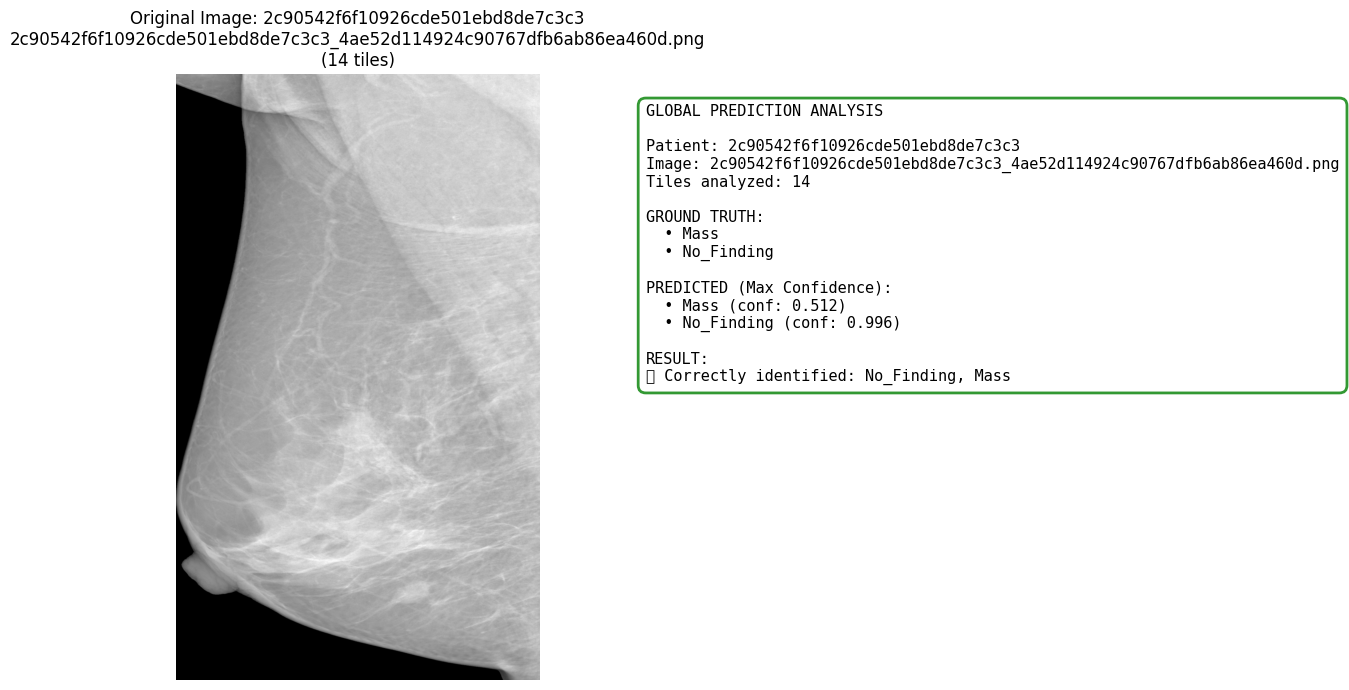


--- IMAGE 2/10 ---


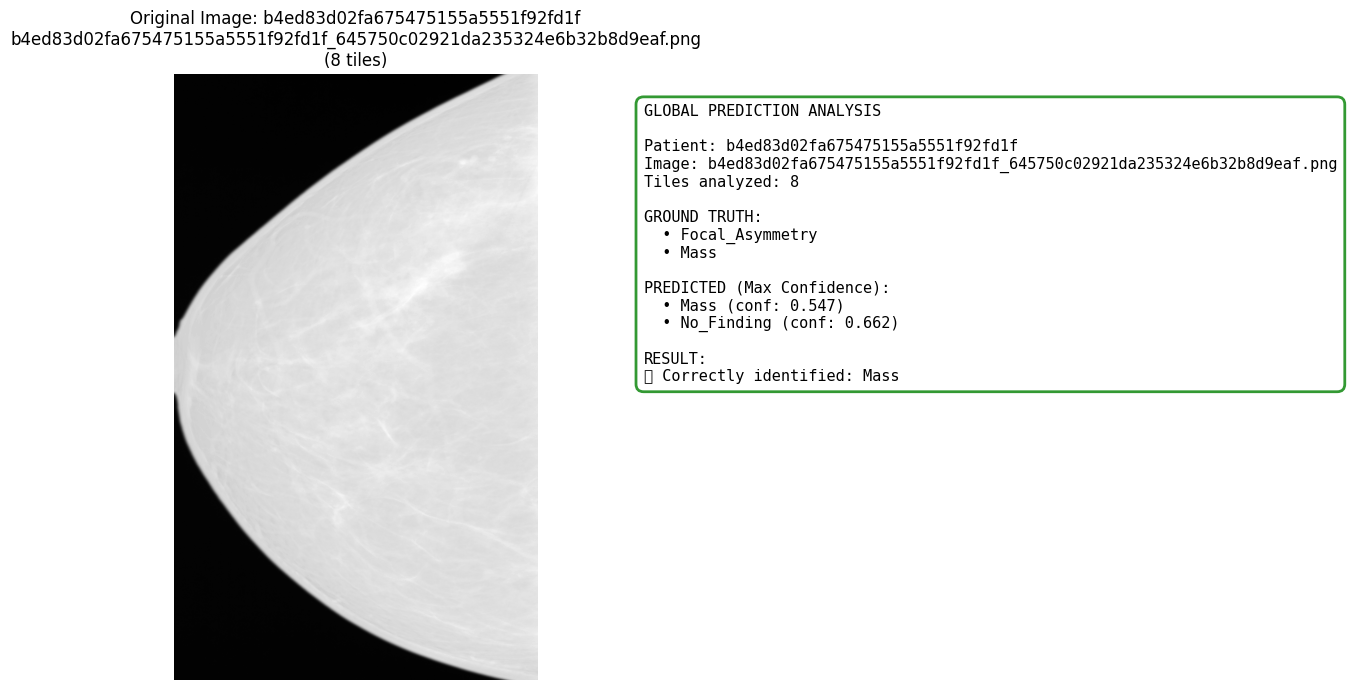


--- IMAGE 3/10 ---


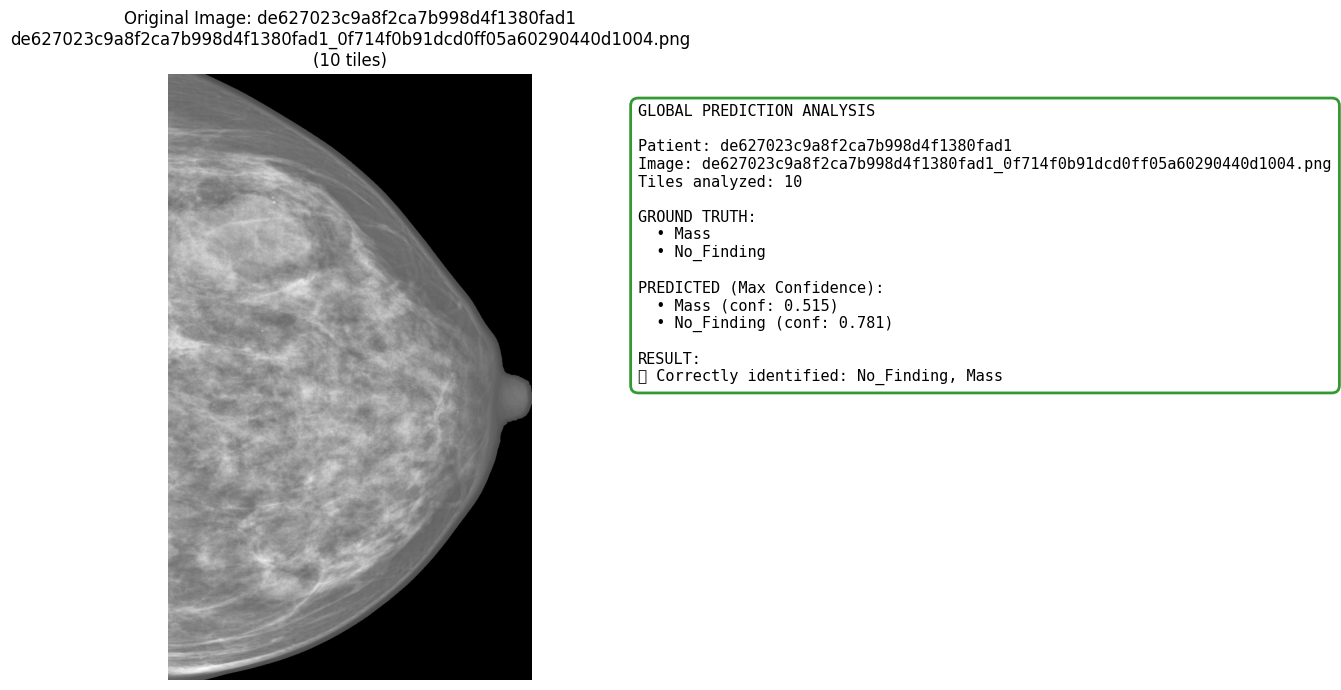


--- IMAGE 4/10 ---


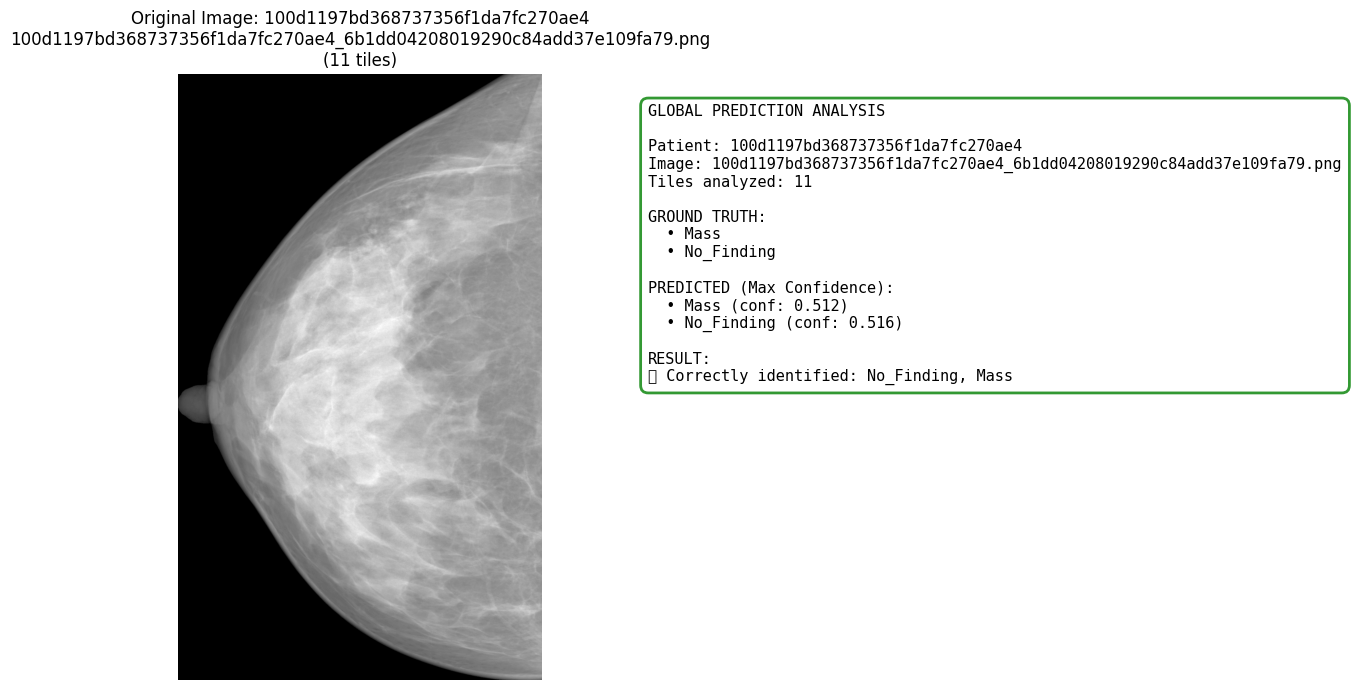


--- IMAGE 5/10 ---


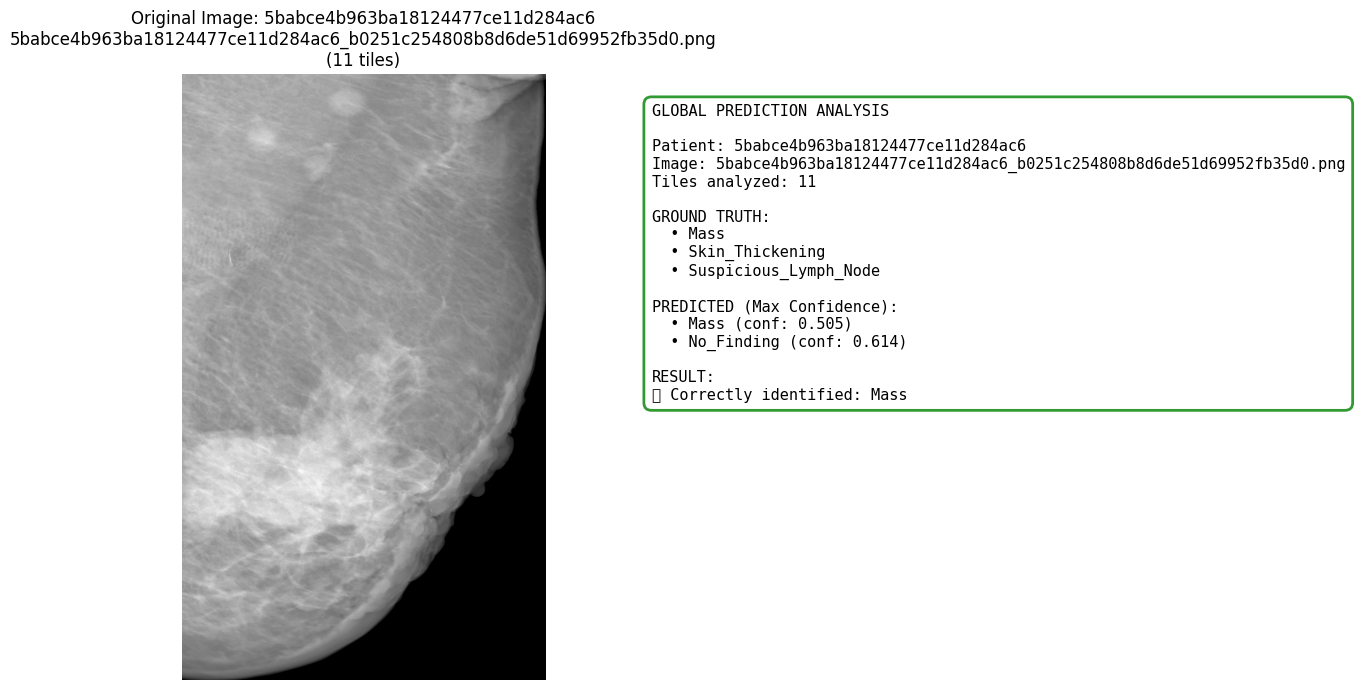


--- IMAGE 6/10 ---


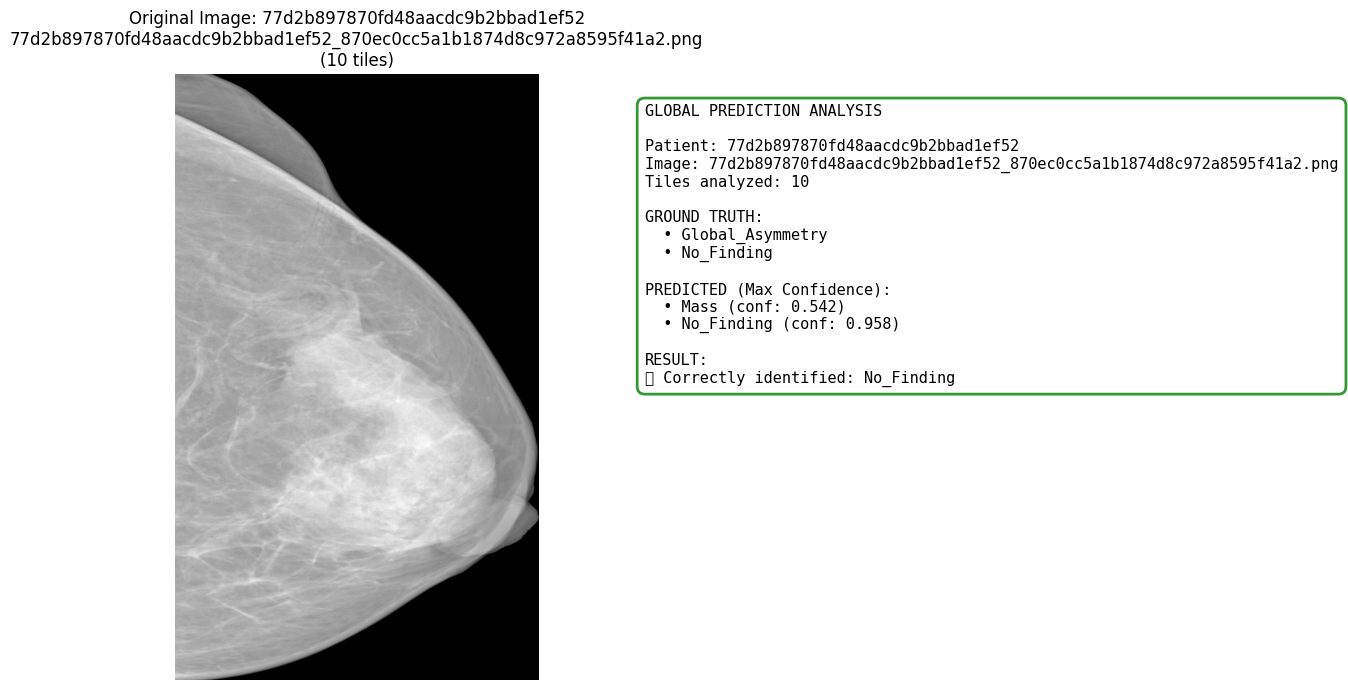


--- IMAGE 7/10 ---


/tmp/ipykernel_17461/4291019921.py:107: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/pranaypalem/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


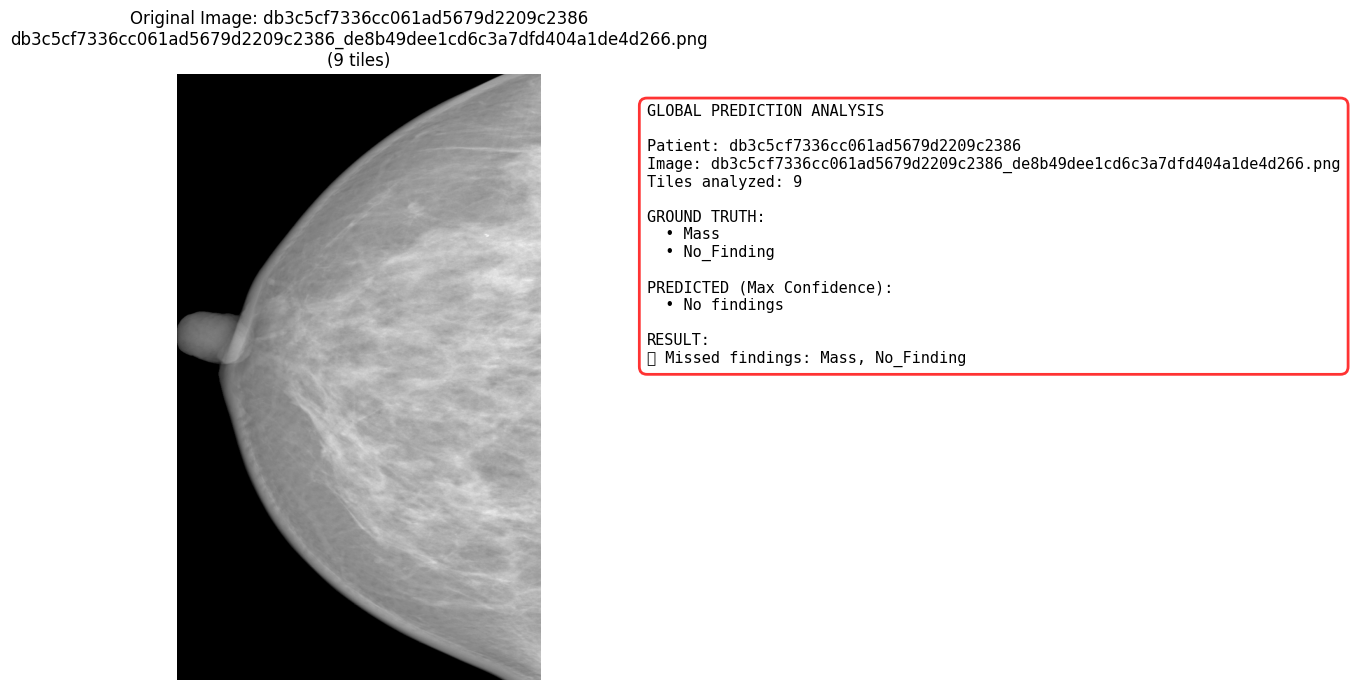


--- IMAGE 8/10 ---


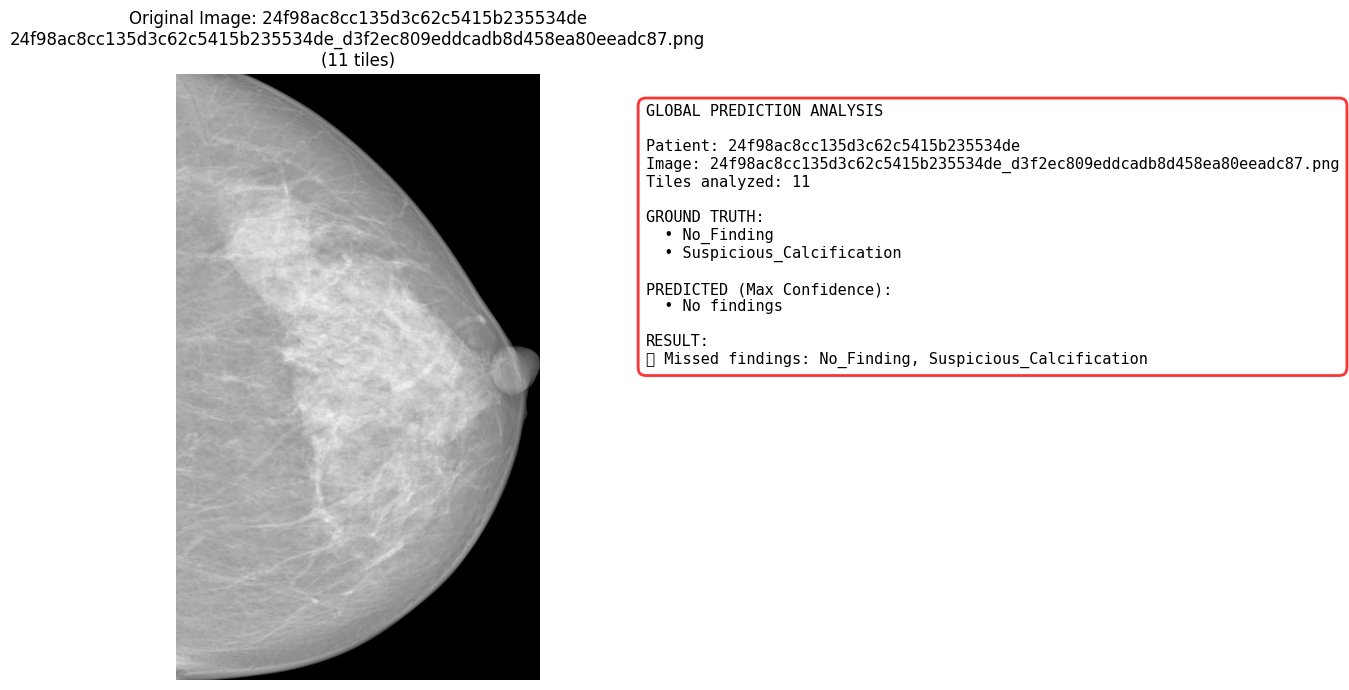


--- IMAGE 9/10 ---


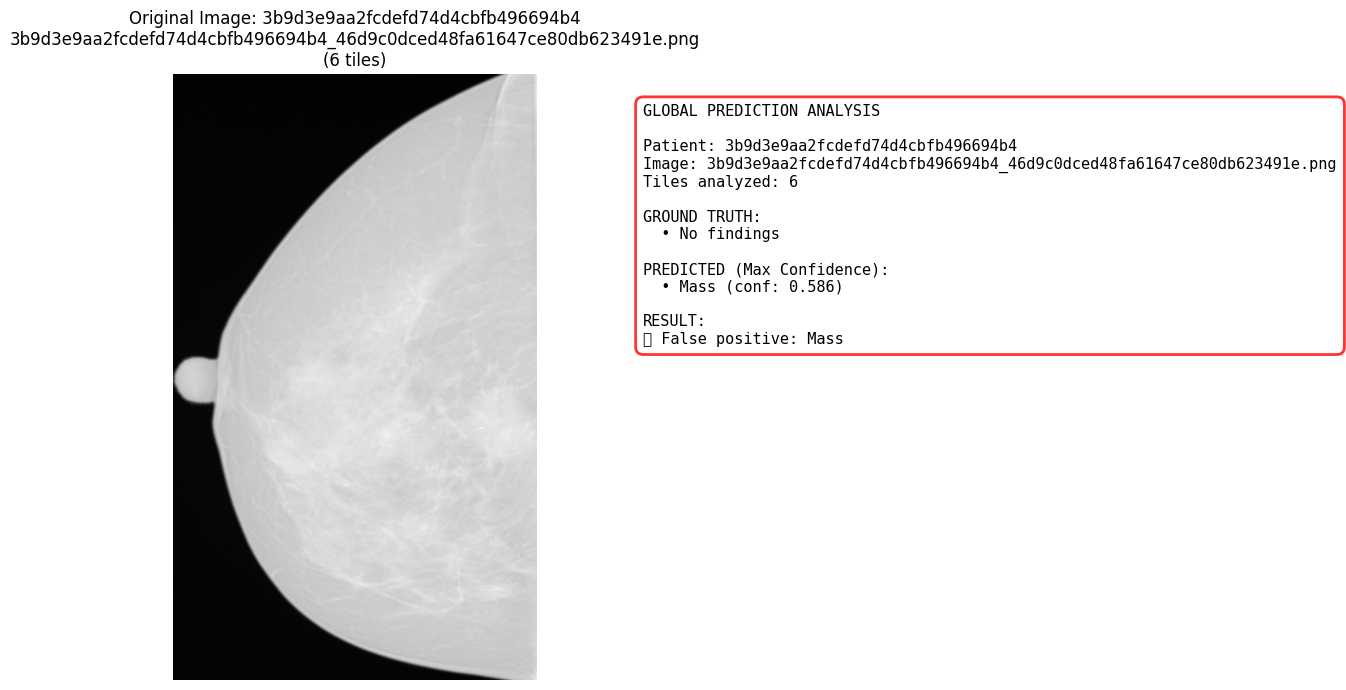


--- IMAGE 10/10 ---


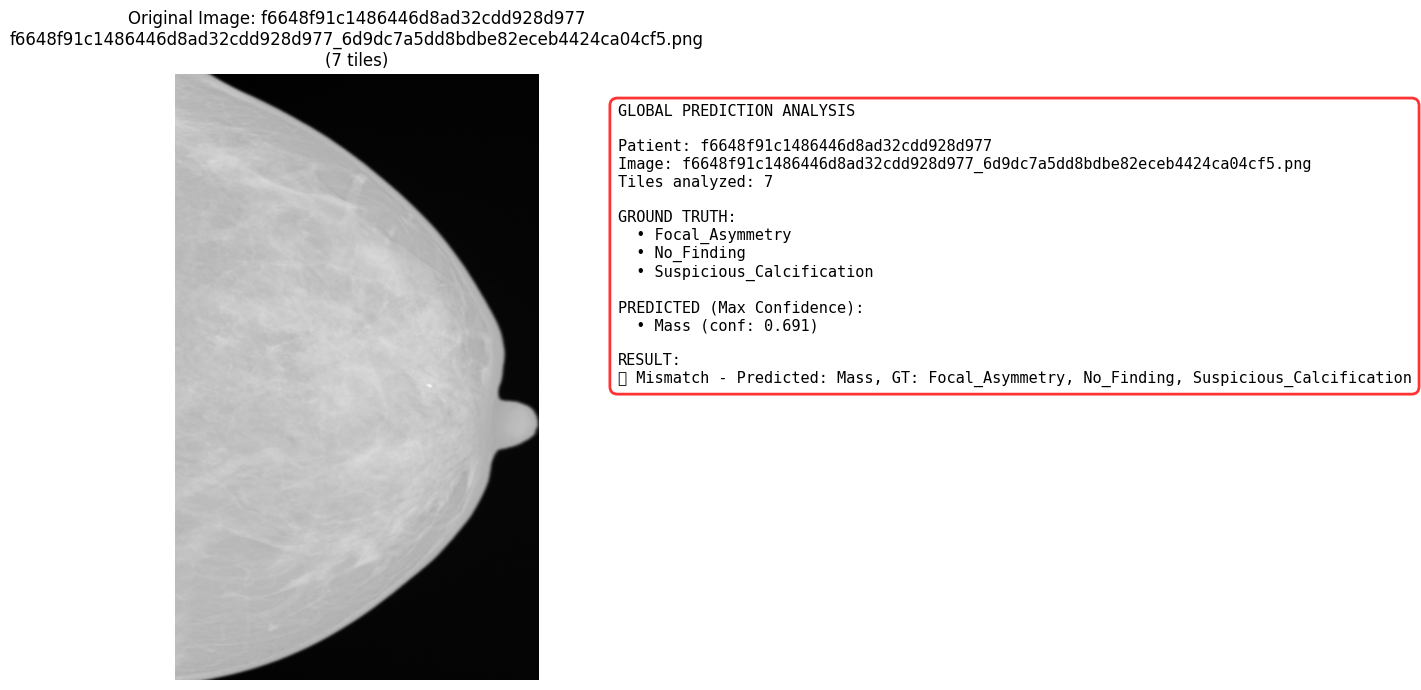


📊 GLOBAL PREDICTION SUMMARY
Voting method used: Max Confidence
Total images analyzed: 357
Overall accuracy: 0.898
Sample images shown: 10
Correct predictions in sample: 6/10 (60.0%)

✅ Global sample analysis completed!


In [21]:
def get_finding_names(prediction_array: np.ndarray, class_names: List[str], threshold: float = 0.5) -> List[str]:
    """Get list of finding names from prediction array."""
    findings = []
    for i, class_name in enumerate(class_names):
        if prediction_array[i] >= threshold:
            findings.append(class_name)
    return findings if findings else ['No_Finding']

def compare_predictions_with_ground_truth(pred_findings: List[str], gt_findings: List[str]) -> Tuple[bool, str]:
    """Compare predictions with ground truth and return correctness and description."""
    
    # Handle No_Finding case
    pred_has_findings = len(pred_findings) > 0 and pred_findings != ['No_Finding']
    gt_has_findings = len(gt_findings) > 0 and gt_findings != ['No_Finding']
    
    if not pred_has_findings and not gt_has_findings:
        return True, "✅ Correctly identified no findings"
    elif not pred_has_findings and gt_has_findings:
        return False, f"❌ Missed findings: {', '.join(gt_findings)}"
    elif pred_has_findings and not gt_has_findings:
        return False, f"❌ False positive: {', '.join(pred_findings)}"
    else:
        # Both have findings - check for matches
        matches = set(pred_findings) & set(gt_findings)
        if matches:
            return True, f"✅ Correctly identified: {', '.join(matches)}"
        else:
            return False, f"❌ Mismatch - Predicted: {', '.join(pred_findings)}, GT: {', '.join(gt_findings)}"

def visualize_global_prediction(image_key: str, global_data: Dict, original_images_dir: str = 'split_images/test'):
    """Visualize global prediction for a single image."""
    
    patient_id = global_data['patient_id']
    image_id = global_data['image_id']
    
    # Get predictions and ground truth
    gt_findings = get_finding_names(global_data['global_ground_truth'], CONFIG['class_names'])
    pred_findings = get_finding_names(global_data['global_prediction'], CONFIG['class_names'], CONFIG['confidence_threshold'])
    
    # Compare predictions with ground truth
    is_correct, comparison_text = compare_predictions_with_ground_truth(pred_findings, gt_findings)
    
    # Load original image
    original_image_path = Path(original_images_dir) / image_id
    if not original_image_path.exists():
        original_image_path = Path('split_images/training') / image_id
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # 1. Original image
    if original_image_path.exists():
        try:
            orig_img = Image.open(original_image_path)
            axes[0].imshow(orig_img, cmap='gray')
            
            # Add tile grid overlay to show tile locations
            img_width, img_height = orig_img.size
            for tile_data in global_data['tile_predictions']:
                # This is a simplified visualization - would need actual tile coordinates
                pass
            
            axes[0].set_title(f'Original Image: {patient_id}\n{image_id}\n({global_data["num_tiles"]} tiles)')
        except Exception as e:
            axes[0].text(0.5, 0.5, f'Error loading\noriginal image:\n{str(e)}', 
                        ha='center', va='center', transform=axes[0].transAxes, fontsize=10)
    else:
        axes[0].text(0.5, 0.5, f'Original image\nnot found:\n{image_id}', 
                    ha='center', va='center', transform=axes[0].transAxes, fontsize=10)
    axes[0].axis('off')
    
    # 2. Prediction comparison
    axes[1].axis('off')
    
    # Create text summary
    summary_text = f"GLOBAL PREDICTION ANALYSIS\n\n"
    summary_text += f"Patient: {patient_id}\n"
    summary_text += f"Image: {image_id}\n"
    summary_text += f"Tiles analyzed: {global_data['num_tiles']}\n\n"
    
    summary_text += f"GROUND TRUTH:\n"
    if gt_findings == ['No_Finding']:
        summary_text += f"  • No findings\n\n"
    else:
        for finding in gt_findings:
            summary_text += f"  • {finding}\n"
        summary_text += "\n"
    
    summary_text += f"PREDICTED ({best_method.replace('_', ' ').title()}):\n"
    if pred_findings == ['No_Finding']:
        summary_text += f"  • No findings\n\n"
    else:
        for finding in pred_findings:
            confidence = global_data['global_prediction'][CONFIG['class_names'].index(finding)]
            summary_text += f"  • {finding} (conf: {confidence:.3f})\n"
        summary_text += "\n"
    
    summary_text += f"RESULT:\n{comparison_text}"
    
    # Set text color based on correctness
    text_color = 'green' if is_correct else 'red'
    
    axes[1].text(0.05, 0.95, summary_text, 
                transform=axes[1].transAxes, fontsize=11, 
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8, edgecolor=text_color, linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
    return is_correct

# Select 10 diverse images for analysis
print(f"Selecting {CONFIG['num_samples_to_show']} diverse images for global analysis...")

# Use best performing voting method
best_results = voting_results[best_method]

# Separate correct and incorrect predictions
correct_images = []
incorrect_images = []

for image_key, global_data in best_results.items():
    gt_findings = get_finding_names(global_data['global_ground_truth'], CONFIG['class_names'])
    pred_findings = get_finding_names(global_data['global_prediction'], CONFIG['class_names'], CONFIG['confidence_threshold'])
    is_correct, _ = compare_predictions_with_ground_truth(pred_findings, gt_findings)
    
    if is_correct:
        correct_images.append(image_key)
    else:
        incorrect_images.append(image_key)

# Select a mix of correct and incorrect predictions
np.random.seed(42)
selected_correct = np.random.choice(correct_images, min(6, len(correct_images)), replace=False)
selected_incorrect = np.random.choice(incorrect_images, min(4, len(incorrect_images)), replace=False)
selected_images = list(selected_correct) + list(selected_incorrect)

print(f"Selected {len(selected_images)} images:")
print(f"  • {len(selected_correct)} correct predictions")
print(f"  • {len(selected_incorrect)} incorrect predictions")

# Display each selected image
correct_count = 0
total_count = 0

print(f"\n{'='*100}")
print(f"🎯 GLOBAL PREDICTIONS ANALYSIS - {best_method.replace('_', ' ').title()} Method")
print(f"{'='*100}")

for idx, image_key in enumerate(selected_images):
    print(f"\n--- IMAGE {idx + 1}/{len(selected_images)} ---")
    global_data = best_results[image_key]
    
    is_correct = visualize_global_prediction(image_key, global_data)
    
    if is_correct:
        correct_count += 1
    total_count += 1

# Summary statistics
print(f"\n{'='*80}")
print(f"📊 GLOBAL PREDICTION SUMMARY")
print(f"{'='*80}")
print(f"Voting method used: {best_method.replace('_', ' ').title()}")
print(f"Total images analyzed: {len(best_results)}")
print(f"Overall accuracy: {global_metrics[best_method]['overall_accuracy']:.3f}")
print(f"Sample images shown: {total_count}")
print(f"Correct predictions in sample: {correct_count}/{total_count} ({correct_count/total_count*100:.1f}%)")

print(f"\n✅ Global sample analysis completed!")

## Performance Visualizations

Available tile metric keys: ['Architectural_Distortion', 'Asymmetry', 'Focal_Asymmetry', 'Global_Asymmetry', 'Mass', 'Nipple_Retraction', 'No_Finding', 'Skin_Retraction', 'Skin_Thickening', 'Suspicious_Calcification', 'Suspicious_Lymph_Node', 'overall']
Available classes in tile_metrics: 11 of 11


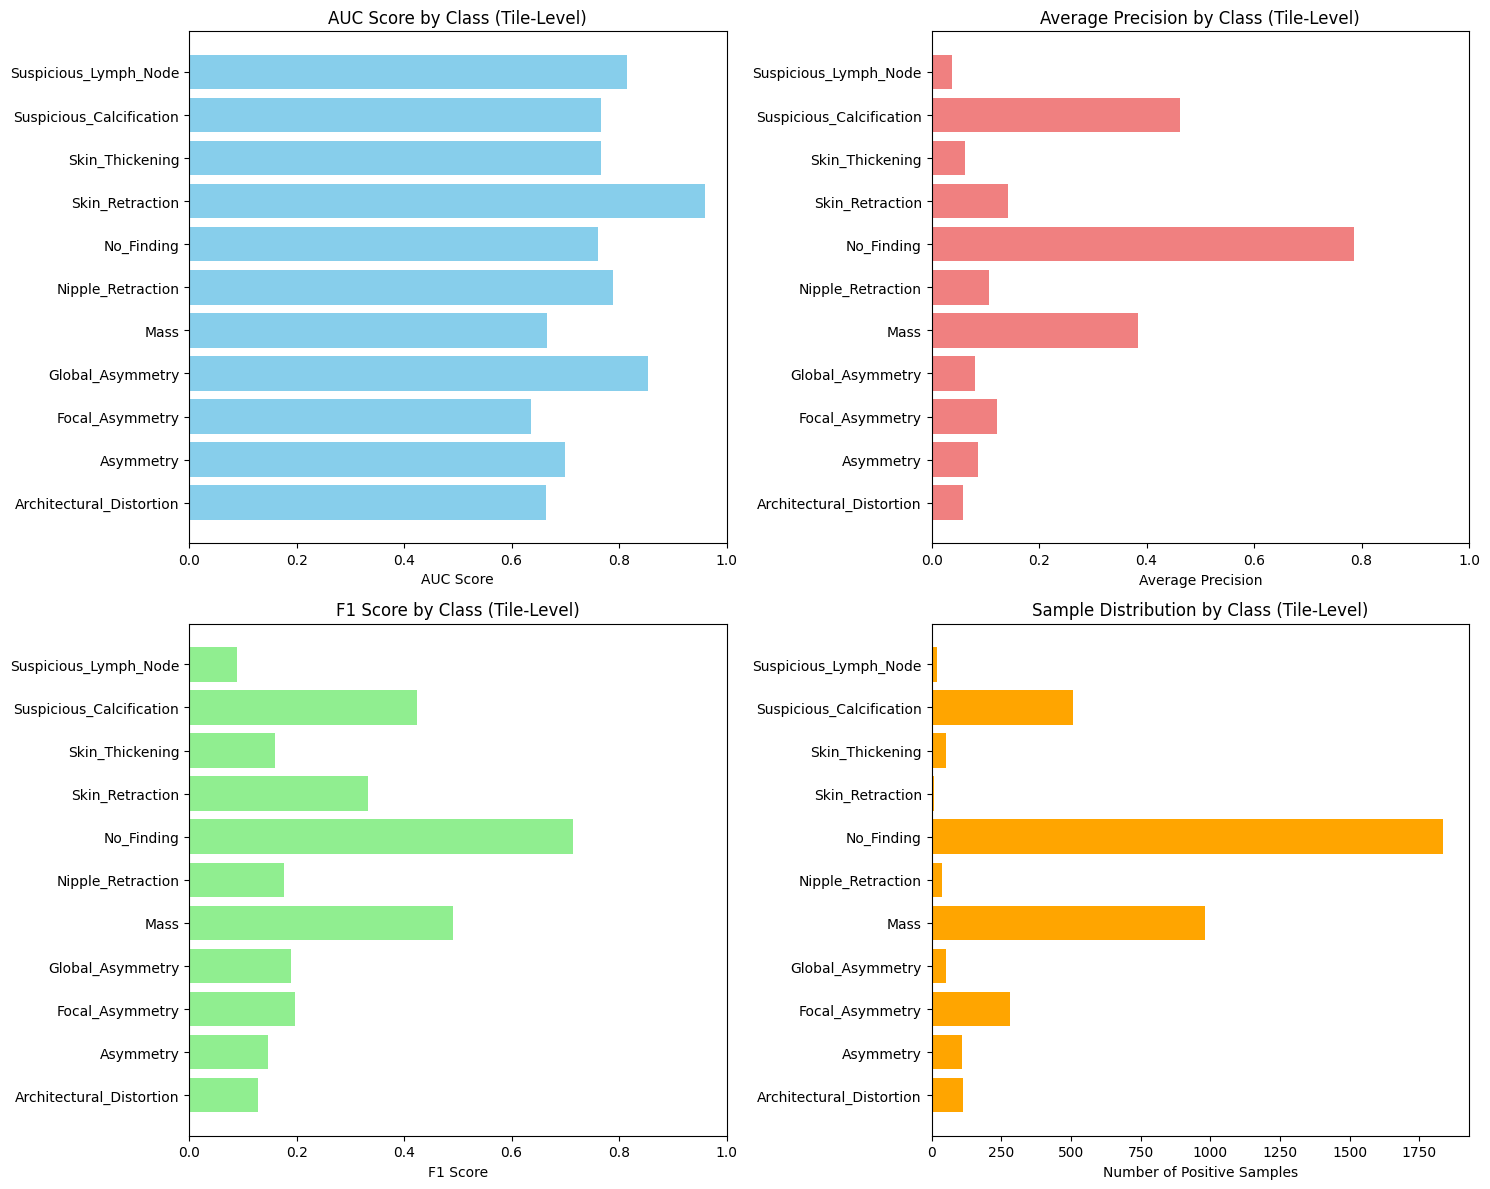


📊 Tile-Level Performance Summary:
   Mean AUC: 0.762
   Mean AP:  0.212
   Mean F1:  0.277
   Total Samples: 3,614


In [22]:
# Create performance visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Extract tile-level metrics for plotting
print("Available tile metric keys:", list(tile_metrics.keys()))

class_names = CONFIG['class_names']
# Filter to only include classes that exist in tile_metrics
available_classes = [cls for cls in class_names if cls in tile_metrics]
print(f"Available classes in tile_metrics: {len(available_classes)} of {len(class_names)}")

if available_classes:
    aucs = [tile_metrics[cls]['auc'] for cls in available_classes]
    aps = [tile_metrics[cls]['ap'] for cls in available_classes]
    f1s = [tile_metrics[cls]['f1'] for cls in available_classes]
    pos_samples = [tile_metrics[cls]['positive_samples'] for cls in available_classes]
    
    # AUC by class
    axes[0, 0].barh(available_classes, aucs, color='skyblue')
    axes[0, 0].set_xlabel('AUC Score')
    axes[0, 0].set_title('AUC Score by Class (Tile-Level)')
    axes[0, 0].set_xlim(0, 1)

    # Average Precision by class
    axes[0, 1].barh(available_classes, aps, color='lightcoral')
    axes[0, 1].set_xlabel('Average Precision')
    axes[0, 1].set_title('Average Precision by Class (Tile-Level)')
    axes[0, 1].set_xlim(0, 1)

    # F1 Score by class
    axes[1, 0].barh(available_classes, f1s, color='lightgreen')
    axes[1, 0].set_xlabel('F1 Score')
    axes[1, 0].set_title('F1 Score by Class (Tile-Level)')
    axes[1, 0].set_xlim(0, 1)

    # Sample distribution
    axes[1, 1].barh(available_classes, pos_samples, color='orange')
    axes[1, 1].set_xlabel('Number of Positive Samples')
    axes[1, 1].set_title('Sample Distribution by Class (Tile-Level)')
else:
    print("No valid class metrics found!")
    for ax in axes.flat:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Overall tile-level metrics summary
if 'overall' in tile_metrics:
    overall = tile_metrics['overall']
    print(f"\n📊 Tile-Level Performance Summary:")
    print(f"   Mean AUC: {overall['mean_auc']:.3f}")
    print(f"   Mean AP:  {overall['mean_ap']:.3f}")
    print(f"   Mean F1:  {overall['mean_f1']:.3f}")
    print(f"   Total Samples: {overall['total_samples']:,}")
else:
    print("\nNo overall tile-level metrics found!")

## Evaluation Summary

In [23]:
# Final summary
print("="*80)
print("🔬 MAMMOGRAM CLASSIFICATION EVALUATION SUMMARY WITH GLOBAL PREDICTIONS")
print("="*80)

# Safely access overall tile-level metrics
if 'overall' in tile_metrics:
    overall = tile_metrics['overall']
    print(f"\n📊 Dataset Information:")
    print(f"   Total test samples (tiles): {overall['total_samples']:,}")
    print(f"   Total unique images: {len(image_groups)}")
    print(f"   Number of classes: {overall['classes_evaluated']}")
    print(f"   Model checkpoint: {CONFIG['checkpoint_path']}")

    print(f"\n🎯 Tile-Level Performance:")
    print(f"   Mean AUC: {overall['mean_auc']:.3f}")
    print(f"   Mean Average Precision: {overall['mean_ap']:.3f}")
    print(f"   Mean F1 Score: {overall['mean_f1']:.3f}")
    print(f"   Mean Accuracy: {overall['mean_accuracy']:.3f}")
else:
    print(f"\n📊 Dataset Information:")
    print(f"   Total unique images: {len(image_groups)}")
    print(f"   Model checkpoint: {CONFIG['checkpoint_path']}")
    print(f"\n⚠️ Overall tile-level metrics not available")

print(f"\n🗳️  Global Image-Level Performance:")
for method in CONFIG['voting_methods']:
    method_name = method.replace('_', ' ').title()
    accuracy = global_metrics[method]['overall_accuracy']
    marker = "🏆" if method == best_method else "  "
    print(f"   {marker} {method_name}: {accuracy:.3f}")

print(f"\n🏆 Best Global Method: {best_method.replace('_', ' ').title()}")
print(f"   Global Accuracy: {global_metrics[best_method]['overall_accuracy']:.3f}")
print(f"   Images Evaluated: {global_metrics[best_method]['total_images']}")

# Best and worst performing classes - only if we have class metrics
available_classes = [cls for cls in CONFIG['class_names'] if cls in tile_metrics]
if available_classes:
    class_aucs = [(cls, tile_metrics[cls]['auc']) for cls in available_classes if tile_metrics[cls]['auc'] > 0]
    class_aucs.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🏆 Best Performing Classes (by AUC):") 
    for i, (cls, auc) in enumerate(class_aucs[:3]):
        print(f"   {i+1}. {cls}: {auc:.3f}")

    print(f"\n⚠️  Most Challenging Classes (by AUC):")
    for i, (cls, auc) in enumerate(class_aucs[-3:]):
        print(f"   {len(class_aucs)-i}. {cls}: {auc:.3f}")

    # Sample distribution insights
    total_positives = sum(tile_metrics[cls]['positive_samples'] for cls in available_classes)
    print(f"\n📈 Dataset Balance:")
    print(f"   Total positive findings: {total_positives:,}")
    print(f"   Average positives per class: {total_positives / len(available_classes):.1f}")

    # Most common findings
    sample_counts = [(cls, tile_metrics[cls]['positive_samples']) for cls in available_classes]
    sample_counts.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🔍 Most Common Findings:")
    for cls, count in sample_counts[:5]:
        if 'overall' in tile_metrics:
            percentage = (count / overall['total_samples']) * 100
            print(f"   {cls}: {count:,} samples ({percentage:.1f}%)")
        else:
            print(f"   {cls}: {count:,} samples")
else:
    print(f"\n⚠️ Class-level metrics not available")

print(f"\n✅ Enhanced evaluation with global predictions completed successfully!")
print(f"📁 Key improvements over tile-level evaluation:")
print(f"   • Global image-level predictions using {len(CONFIG['voting_methods'])} voting methods")
print(f"   • Visual comparison of predictions vs ground truth with ✅/❌ indicators")
if 'selected_images' in locals():
    print(f"   • Analysis of {len(selected_images)} sample images with detailed breakdowns")
print(f"   • Comprehensive voting method comparison and optimal method selection")

🔬 MAMMOGRAM CLASSIFICATION EVALUATION SUMMARY WITH GLOBAL PREDICTIONS

📊 Dataset Information:
   Total test samples (tiles): 3,614
   Total unique images: 357
   Number of classes: 11
   Model checkpoint: classification_models/best_classification_model.pth

🎯 Tile-Level Performance:
   Mean AUC: 0.762
   Mean Average Precision: 0.212
   Mean F1 Score: 0.277
   Mean Accuracy: 0.851

🗳️  Global Image-Level Performance:
   🏆 Max Confidence: 0.898
      Average Confidence: 0.831
      Majority Vote: 0.812
      Weighted Average: 0.831

🏆 Best Global Method: Max Confidence
   Global Accuracy: 0.898
   Images Evaluated: 357

🏆 Best Performing Classes (by AUC):
   1. Skin_Retraction: 0.960
   2. Global_Asymmetry: 0.854
   3. Suspicious_Lymph_Node: 0.815

⚠️  Most Challenging Classes (by AUC):
   11. Mass: 0.666
   10. Architectural_Distortion: 0.664
   9. Focal_Asymmetry: 0.637

📈 Dataset Balance:
   Total positive findings: 3,991
   Average positives per class: 362.8

🔍 Most Common Findings:

In [24]:
# Save enhanced results including global predictions
save_results = input("Save detailed results including global predictions to files? (y/n): ").lower().startswith('y')

if save_results:
    from evaluate_classification import save_detailed_results
    
    output_dir = Path('global_evaluation_results')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save original tile-level results if available
    if 'overall' in tile_metrics and any(cls in tile_metrics for cls in CONFIG['class_names']):
        save_detailed_results(tile_metrics, results_table, output_dir, CONFIG['class_names'])
        print(f"✅ Tile-level results saved")
    else:
        print(f"⚠️ Tile-level metrics not available for saving")
    
    # Save global prediction results
    global_results_path = output_dir / 'global_prediction_results.json'
    with open(global_results_path, 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        serializable_global_metrics = {}
        for method, method_metrics in global_metrics.items():
            serializable_global_metrics[method] = {
                'overall_accuracy': float(method_metrics['overall_accuracy']),
                'total_images': int(method_metrics['total_images']),
                'class_accuracies': {
                    cls: {
                        'accuracy': float(acc_data['accuracy']),
                        'correct': int(acc_data['correct']),
                        'total': int(acc_data['total']),
                        'positive_samples': int(acc_data['positive_samples']),
                        'predicted_positive': int(acc_data['predicted_positive'])
                    }
                    for cls, acc_data in method_metrics['class_accuracies'].items()
                }
            }
        
        summary_data = {
            'total_images_evaluated': len(image_groups),
            'total_tiles_evaluated': len(y_true),
            'best_global_accuracy': float(global_metrics[best_method]['overall_accuracy']),
        }
        
        # Add tile-level accuracy if available
        if 'overall' in tile_metrics:
            summary_data['tile_level_mean_accuracy'] = float(tile_metrics['overall']['mean_accuracy'])
        
        json.dump({
            'voting_methods_comparison': serializable_global_metrics,
            'best_method': best_method,
            'configuration': CONFIG,
            'summary': summary_data
        }, f, indent=2)
    
    print(f"\n💾 Enhanced results saved to: {output_dir}")
    if 'overall' in tile_metrics:
        print(f"   - evaluation_metrics.json (tile-level)")
        print(f"   - evaluation_results.csv (tile-level)")
    print(f"   - global_prediction_results.json (image-level)")
else:
    print("\nResults not saved.")


💾 Results saved:
   Metrics: global_evaluation_results/evaluation_metrics.json
   Table:   global_evaluation_results/evaluation_results.csv
✅ Tile-level results saved

💾 Enhanced results saved to: global_evaluation_results
   - evaluation_metrics.json (tile-level)
   - evaluation_results.csv (tile-level)
   - global_prediction_results.json (image-level)
